# **Skin Cancer Detection**


## **Problem Statement**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. </br>
We will build a multiclass classification model using a custom convolutional neural network in TensorFlow. </br>
The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC).



## **Importing Libraries**

In [28]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Importing Skin Cancer Data**

In [29]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Test")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Set Size: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Set Size: ", image_count_test)

Train Set Size:  2239
Test Set Size:  118


## **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Define some parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Train Set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [34]:
## Validation Set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [35]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## **Visualize the data**
Visualize one instance of all the nine classes present in the dataset

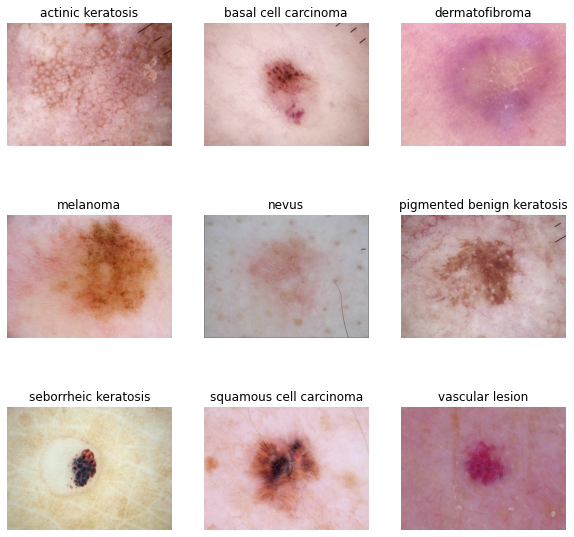

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+"/*.jpg"))[1]))
    plt.imshow(image)
    plt.title(class_names[i])
    plt.axis("off")

In [37]:
for image_batch, labels_batch in train_ds:
  print("Image Batch: ", image_batch.shape)
  print("Labels batch :", labels_batch.shape)
  break


Image Batch:  (32, 180, 180, 3)
Labels batch : (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## **Configure for Performance**

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Create the basic model**
Create a CNN model, which can accurately detect 9 classes present in the dataset. The generic way to build a model in Keras is to instantiate a Sequential model and keep adding keras.layers to it. 

### Build the model

Let's now build the CNN architecture. 
We will build a network with:
*   Three convolutional layers having 16, 32 and 64 filters respectively, each followed by a max pooling layer.
*   Then Flatten the output of the pooling layer to give us a long vector.
*   Then add a fully connected Dense layer with 128 neurons, and finally
add a softmax layer with 9 neurons. </br>
Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`




In [39]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model

In [40]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

### Train the model

In [41]:
# Training for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 66ms/step - loss: 1.9957 - accuracy: 0.2734 - val_loss: 1.7604 - val_accuracy: 0.3937
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 1.5562 - accuracy: 0.4509 - val_loss: 1.5448 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4166 - accuracy: 0.4983 - val_loss: 1.5271 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2874 - accuracy: 0.5541 - val_loss: 1.3904 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2259 - accuracy: 0.5709 - val_loss: 1.5319 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 1s 16ms/step - loss: 1.1810 - accuracy: 0.5686 - val_loss: 1.5010 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.1166 - accuracy: 0.5943 - val_loss: 1.4700 - val_accuracy: 0.5056
Epoch 8/20
5

### Model Summary

In [42]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Visualizing training results

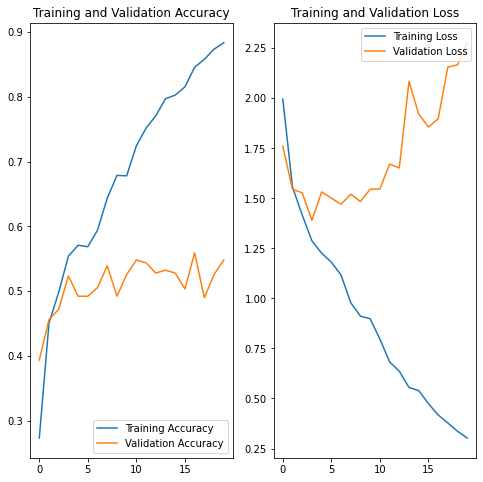

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

##### In the graphs above, the training accuracy and validation accuracy are off by large margins.
The model has achieved only around 50% accuracy on the validation set.
### Overfitting
The training accuracy is increasing linearly but the validation accuracy stays around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable.


## **Augmentation** 
Using data augmentation we will be generating additional training data from the existing examples by augmenting them using random transformations. This helps expose the model to more aspects of the data and generalize better and handle overfitting.

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


### Visualizing the augmented images


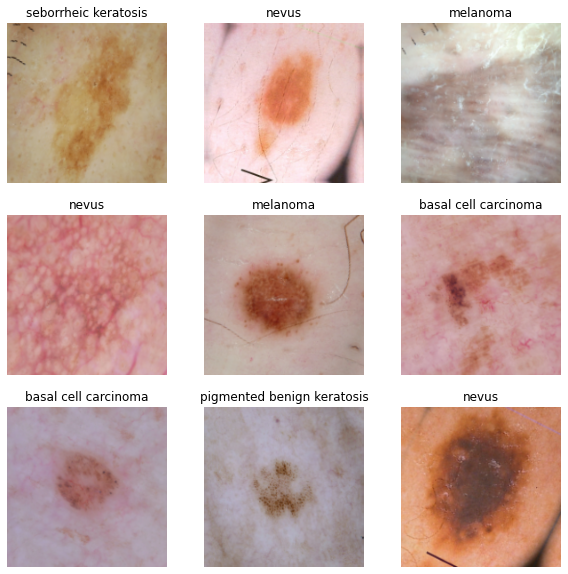

In [49]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

 

### Create the model
**Dropping out** 20% of the output units randomly from the applied layer for overfitting.

In [67]:
# dropout 20% for overfitting
model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

### Compile the model

In [69]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


### Model Summary

In [70]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [71]:
## Training the model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 21ms/step - loss: 1.9992 - accuracy: 0.2533 - val_loss: 1.7963 - val_accuracy: 0.3557
Epoch 2/20
56/56 [==============================] - 1s 19ms/step - loss: 1.7116 - accuracy: 0.3638 - val_loss: 1.5164 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.5199 - accuracy: 0.4754 - val_loss: 1.4968 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4036 - accuracy: 0.5045 - val_loss: 1.4297 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3329 - accuracy: 0.5318 - val_loss: 1.4085 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3181 - accuracy: 0.5262 - val_loss: 1.3680 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.3118 - accuracy: 0.5151 - val_loss: 1.4022 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

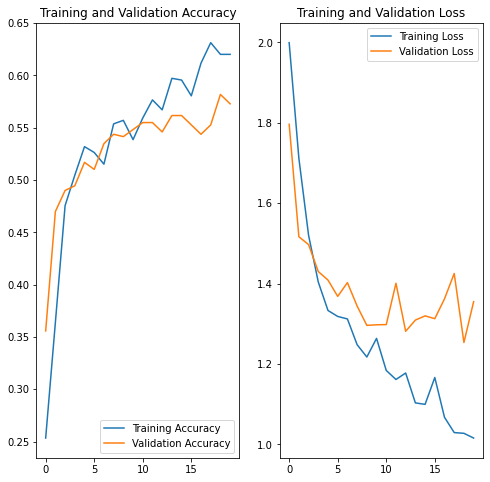

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

##### As seen in the graphs above, the overfitting problem has reduced and the train and validation sets show a linear increase in accuracy. Hence, the new model is an improvement as compared to the previous model.

## **Class Imbalance**

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. We will now check our dataset for any class imbalance.

### Distribution of classes in the training dataset
As a sanity check it is important to check what is the distribution of classes in the data.

In [73]:
# Collect the class data count in an array
count = np.zeros(len(class_names), dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()

In [74]:
# Print the data distribution per class
index = 0
for label in class_names:
  print(label, count[index])
  index = index + 1

actinic keratosis 92
basal cell carcinoma 309
dermatofibroma 77
melanoma 352
nevus 277
pigmented benign keratosis 370
seborrheic keratosis 58
squamous cell carcinoma 142
vascular lesion 115


#### Observation:
Class "*Seborrheic Keratosis*" has the least number of samples - 58. </br>
Class "*Pigmented Benign Keratosis*" has the max number of samples - 370. </br>
~ 1/3 of the samples belong to the classes "*Pigmented Benign Keratosis*" and "*Basal Cell Carcinoma*". </br>
The number of samples in a few classes is less than 100 and this class imbalance needs to be handled for better model building.


### Rectify the class imbalance
Using a python package known as `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

In [75]:
# Install the package
!pip install Augmentor
import Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [76]:
path_to_training_dataset = str(data_dir_train)

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2CF78ABA10>: 100%|██████████| 500/500 [00:18<00:00, 27.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CF78A4E90>: 100%|██████████| 500/500 [00:17<00:00, 27.93 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CFC11BD90>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2CFC11B3D0>: 100%|██████████| 500/500 [01:27<00:00,  5.69 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F2CF6777290>: 100%|██████████| 500/500 [01:18<00:00,  6.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CF78A52D0>: 100%|██████████| 500/500 [00:18<00:00, 26.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F2CFC169410>: 100%|██████████| 500/500 [00:41<00:00, 12.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2CFCD08090>: 100%|██████████| 500/500 [00:17<00:00, 27.83 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/ML/UpGrad/Colab Notebooks/UpGrad Assignments/Cancer Detection CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2CFC14A590>: 100%|██████████| 500/500 [00:17<00:00, 27.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [77]:
# Total number of new images added
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [81]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
len(dataframe_dict_new)

4500

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## **Train the model on the data created using Augmentor**

#### Setting some parameters

In [82]:
batch_size = 32
epochs = 20
img_height = 180
img_width = 180

#### Create a training dataset

In [83]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [85]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [84]:
# Collect the class data count in an array
count = np.zeros(len(class_names), dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
print(count)    

[493 721 455 755 677 773 456 569 493]


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
for image_batch, labels_batch in train_ds:
  print("Image Batch: ", image_batch.shape)
  print("Labels batch :", labels_batch.shape)
  break

Image Batch:  (32, 180, 180, 3)
Labels batch : (32,)


#### Create the model 

In [90]:
num_classes = len(class_names)

model_3 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### Compile the model

In [91]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

####  Train the model

In [92]:
## Training the model for 30 epochs
epochs = 30
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 30s 172ms/step - loss: 1.8670 - accuracy: 0.2975 - val_loss: 1.5181 - val_accuracy: 0.4388
Epoch 2/30
169/169 [==============================] - 31s 178ms/step - loss: 1.4034 - accuracy: 0.4748 - val_loss: 1.4635 - val_accuracy: 0.4625
Epoch 3/30
169/169 [==============================] - 30s 170ms/step - loss: 1.2568 - accuracy: 0.5406 - val_loss: 1.2502 - val_accuracy: 0.5486
Epoch 4/30
169/169 [==============================] - 30s 171ms/step - loss: 1.0848 - accuracy: 0.6061 - val_loss: 1.0868 - val_accuracy: 0.5947
Epoch 5/30
169/169 [==============================] - 30s 173ms/step - loss: 0.9720 - accuracy: 0.6426 - val_loss: 1.1319 - val_accuracy: 0.5872
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 0.8018 - accuracy: 0.7124 - val_loss: 0.8981 - val_accuracy: 0.6793
Epoch 7/30
169/169 [==============================] - 31s 174ms/step - loss: 0.6940 - accuracy: 0.7498 - val_loss: 0.9112 - val_ac

####  Visualize the model results

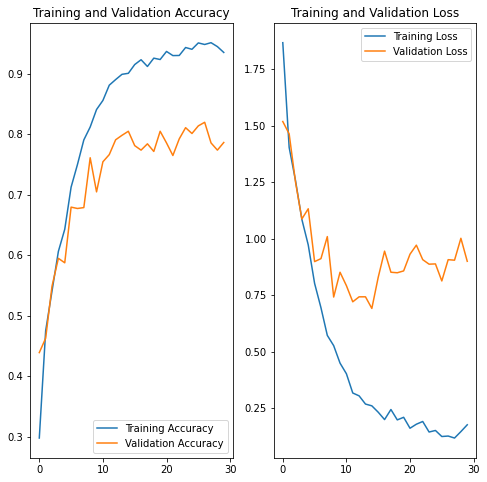

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

As can be seen from the above graphs the training and validation accuracy have improved in the range of 0.8 and the losses have gone down with class balancing.

## **Conclusion**



*  Using a Sequential CNN using 3 convolution layers with 16, 32 nd 64 filters 
respectively, the training accuracy and validation accuracy were off by large margins. The model achieved only around 50% accuracy on the validation set. This was a case of overfitting which had to be resolved.
*  Next, we tried an augmentation strategy of random flip, zoom and rotate which resulted in reduction of overfitting problem and the train and validation sets showed a linear increase in accuracy. Hence, the new model is an improvement as compared to the previous model.
*  On analysis we found that the dataset has class imbalance. </br>
~ 1/3 of the samples belong to the classes "Pigmented Benign Keratosis" and "Basal Cell Carcinoma". The following classes have min. and max. number of images:
  *  "Seborrheic Keratosis" - 58.
  *  "Pigmented Benign Keratosis" - 370. </br>
This class imbalance was handled by adding 500 images to each class and rebuilding the model and training it on the dataset resulted in improved accuracy and reduced losses.